<a href="https://colab.research.google.com/github/tompc35/oceanography-notebooks/blob/master/Abyssal_Recipes/Abyssal_Recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abyssal Recipes

This notebook demonstrates Munk's advection-diffusion model for advection and diffusion in the deep ocean. The simple model for T, S and C14 is compared with bottle data from the WOCE P14 line.

reference: Munk (1966), Abyssal Recipes, Deep-Sea Research, 1966, Vol. 13, pp. 707 to 730

data: http://cchdo.ucsd.edu/cruise/49NZ20071122

Tom Connolly
tconnolly@mlml.calstate.edu

### First read the data

No need to alter this part.

In [1]:
!git clone https://github.com/tompc35/oceanography-notebooks.git

Cloning into 'oceanography-notebooks'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 98 (delta 10), reused 0 (delta 0), pack-reused 76
Unpacking objects: 100% (98/98), done.


In [2]:
import  numpy as np
import csv
import matplotlib.pyplot as plt

data_file = 'oceanography-notebooks/Abyssal_Recipes/p14c_hy1.csv' # WOCE exchange bottle file
hdrrow = 6 # number of rows in header

f = open(data_file)
csvraw = list(csv.reader(f))
ncols = np.shape(csvraw[hdrrow+1])[0]

firstcol = 2
data = np.genfromtxt(data_file, 
                     delimiter=',', 
                     skip_header=hdrrow, 
                     skip_footer=1, 
                     usecols=(np.arange(firstcol,ncols)))
f.close()

data[data == -999.] = np.nan
data = np.array(data)

col_depth = csvraw[hdrrow-1].index('DEPTH')-firstcol
col_pr = csvraw[hdrrow-1].index('CTDPRS')-firstcol
col_temp = csvraw[hdrrow-1].index('CTDTMP')-firstcol
col_sal = csvraw[hdrrow-1].index('CTDSAL')-firstcol
col_c14 = csvraw[hdrrow-1].index('DELC14')-firstcol
col_stn = csvraw[hdrrow-1].index('STNNBR')-firstcol

depth = data[:,col_depth]
pr = data[:,col_pr]
temp = data[:,col_temp]
sal = data[:,col_sal]
c14 = data[:,col_c14]
stn = data[:,col_stn]

# Adjust model parameters

k - eddy diffusivity [m$^2$/s]

w - vertical velocity [m/s]

In [3]:
k = 1.0e-2
w = 1.0e-7

#### Additional parameters following Munk (1966)

``muC`` : $\mu_c$ - C14 decay rate (s$^{-1}$)

``wkratio``   : w/k - ratio of vertical velocity (w [m/s]) to vertical diffusivity (k [m$^2$/s])

``lmda`` : $\lambda = 1 + 4 \frac{k  \mu_c}{w^2}$ 

In [4]:
muC = 3.93e-12 # C14 decay rate (s^-1)
wkratio = w/k  
lmda = 1 + 4*k*muC/(w**2) # lambda^2 = 1 + 4 (k*muC/w^2)

# Define end members and compare modeled profiles with data

### Temperature and salinity

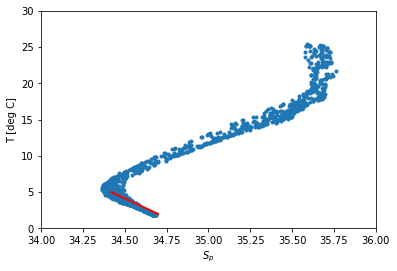

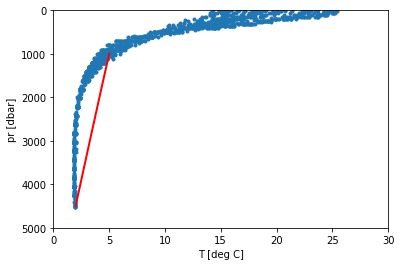

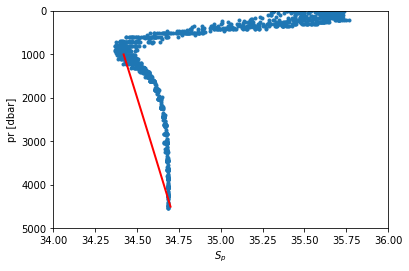

In [5]:
# water mass 1 (deepest)
T1 = 2.00      # temperature
S1 = 34.7       # salinity
z1 = -4500.    # vertical coordinate (depth, negative)

# water mass 2 (intermediate) 
T2 = 5.       # temperature
S2 = 34.42       # salinity
z2 = -1000.    # vertical coordinate (depth, negative)

z = np.linspace(z1,z2,100)
ksi = (z-z1)/(z2-z1)

wkratio_salt = wkratio      # salt

gamma = (z2-z1)*wkratio
T = T1 + (T2-T1)*(np.exp(gamma*ksi)-1)/(np.exp(gamma)-1)

gammaS = (z2-z1)*wkratio_salt
S = S1 + (S2-S1)*(np.exp(gammaS*ksi)-1)/(np.exp(gammaS)-1)

plt.figure()
plt.plot(sal,temp,'.')
plt.plot(S,T,'r-',lw=2)
plt.xlim((34.,36.))   # set x-axis limits
plt.ylim((0,30))   # set y-axis limits
plt.xlabel("$S_p$")
plt.ylabel("T [deg C]")

plt.figure()
plt.plot(temp,pr,'.')
plt.plot(T,-z,'r-',lw=2)
plt.xlabel("T [deg C]")
plt.ylabel("pr [dbar]")
plt.xlim((0,30))   # set x-axis limits
plt.ylim((0,5000)) # set y-axis limits
plt.gca().invert_yaxis()

plt.figure()
plt.plot(sal,pr,'.')
plt.plot(S,-z,'r-',lw=2)
plt.xlim((34.,36.))   # set x-axis limits
plt.ylim((0,5000)) # set y-axis limits
plt.xlabel("$S_p$")
plt.ylabel("pr [dbar]")
plt.gca().invert_yaxis()

### Carbon-14

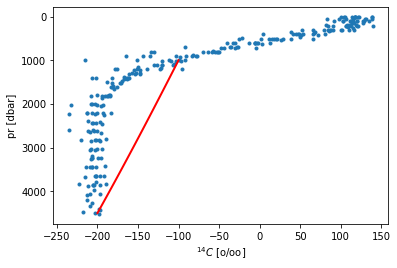

In [6]:
C1 = -200.  # C14 value in deepest water
C2 = -100.  # C14 value in intermediate water

Cplus  =  (C2 - C1*np.exp(0.5*gamma*(1-lmda)))/(np.exp(0.5*gamma*(1+lmda))-np.exp(0.5*gamma*(1-lmda)))
Cminus = -(C2 - C1*np.exp(0.5*gamma*(1+lmda)))/(np.exp(0.5*gamma*(1+lmda))-np.exp(0.5*gamma*(1-lmda)))
C = Cplus*np.exp(0.5*gamma*(1+lmda)*ksi)+Cminus*np.exp(0.5*gamma*(1-lmda)*ksi)

plt.figure()
plt.plot(c14,pr,'.')
plt.plot(C,-z,'r-',lw=2)
plt.xlabel('$^{14}C$ [o/oo]')
plt.ylabel('pr [dbar]')
plt.gca().invert_yaxis()